In [18]:
import numpy as np
from library_dicom.dicom_processor.tools.create_mip import *
import matplotlib.pyplot as plt
#from radiomics.featureextractor import *
from sklearn import mixture

from library_dicom.post_processing.PostProcess_Reader import PostProcess_Reader
from library_dicom.post_processing.Mask4D import Mask4D
#from library_dicom.post_processing.GaussianModel import GaussianModel
from library_dicom.post_processing.WatershedModel import WatershedModel 

In [19]:
import SimpleITK as sitk  
mask_path = r'C:\Users\wendy\Documents\STAGE\gained\1.2.250.1.74.20130607110000.4000014017745_nifti_mask.nii'
pet_path = r'C:\Users\wendy\Documents\STAGE\gained\1.2.250.1.74.20130607110000.4000014017745_nifti_PT.nii'

#mask_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/GAINED_NIFTI/11011101061005/pet0/1.2.250.1.74.20130607110000.4000014017745_nifti_mask.nii'
#pet_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/GAINED_NIFTI/11011101061005/pet0/1.2.250.1.74.20130607110000.4000014017745_nifti_PT.nii'

In [20]:
model = WatershedModel(mask_path, pet_path, type = '4d')

In [21]:
ws_array, label_number = model.watershed_model(0.41)

In [22]:
label_number 

61

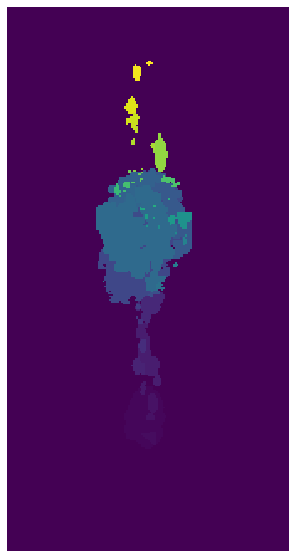

In [23]:
mip_imshow(ws_array, 0, cmap='viridis', type = 'mask')

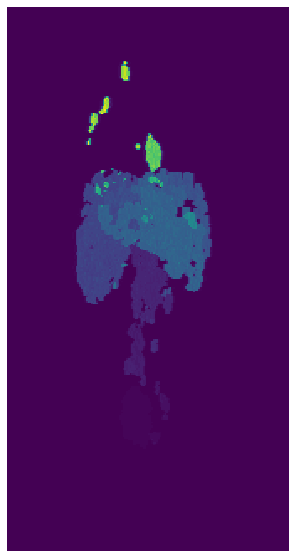

In [24]:
mip_imshow(ws_array, 45, cmap='viridis', type = 'mask')

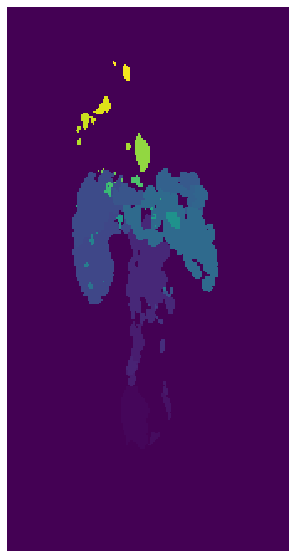

In [16]:
mip_imshow(ws_array, 90, cmap='viridis', type = 'mask')

In [ ]:
#difference with juste connected component 

In [8]:
labelle_array = model.get_labelled_threshold_mask_array(model.get_labelled_threshold_mask_img(model.get_binary_threshold_mask_img(0.41)))

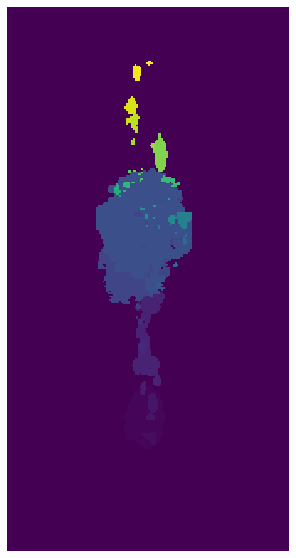

In [9]:
mip_imshow(labelle_array, 0, cmap = 'viridis', type = 'mask')

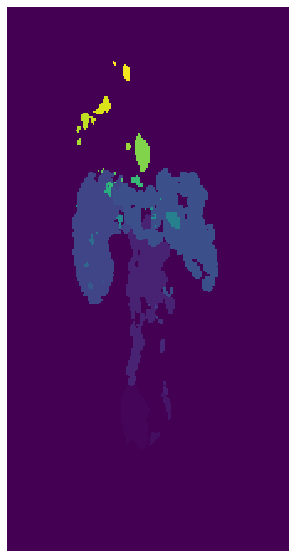

In [10]:
mip_imshow(labelle_array, 90, cmap = 'viridis', type = 'mask')